In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load constants
FREQ_START = 1419.84
FREQ_STEP = 0.00781250
RECORDINGMODE = 4
NBINS = 148
tsys = 0

In [3]:
# set data indices
CMD = 0
DATA_START = 12

# load data from rad file. 
# returns calibration tsys and a matrix where each row has form:
# CMD, TIMESTAMP, AZ, EL, AZOFF, ELOFF, GLON, GLAT, FREQ_START, FREQ_STEP, RECORDINGMODE, # OF BINS, *DATA (in K)
def load_data(file):
    with open(file) as f:
        data = []
        lines = f.readlines()
        for i in range(len(lines)):
            if 'cmd' in lines[i]: # comments with 'cmd' indicate execution of a line from the .cmd file
                data.append([lines[i]] + lines[i+1].split()[:-2]) # ignore vlsr data
            elif 'tsys' in lines[i]:
                tsys = int(lines[i].split()[2]) # hardcode location of tsys value
        return tsys, np.array(data)

# Sun Sweep Analysis

In [4]:
# load data to tsys, raw
file = '21cm/sunsweeps/171103-01.rad'
tsys, raw = load_data(file)

In [5]:
# select rows to analyze
# TODO: make more robust selection mechanism (perhaps by adding comments to the cmd file?)
azsweep = np.array([row for row in raw if ('offset' in row[CMD] and '0' == row[CMD][-2])])
elsweep = np.array([row for row in raw if 'offset 0' in row[CMD]])

# 171103-01.rad is an invalid file. so here's a temporary fix:
azsweep = azsweep[:31]

In [46]:
def remove_background(sweep, tsys):
    remove_background = sweep - tsys
    drop_negatives = np.where(remove_background > 0, remove_background, 0)
    return drop_negatives

def antennaT_to_brightnessT(sweep):
    ANTENNA_ANG_DIAM = 7
    SOURCE_ANG_DIAM = .5
    POLARIZATION_FACTOR = 2 # antenna only measures 1 polarization direction
    return sweep * (ANTENNA_ANG_DIAM / SOURCE_ANG_DIAM)**2 * POLARIZATION_FACTOR

[  0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           9.99864865  25.23310811
  46.29054054  68.37027027  83.31824324  93.63986486  88.3         81.13175676
  60.77972973  42.22162162  19.83378378   8.17094595   0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]


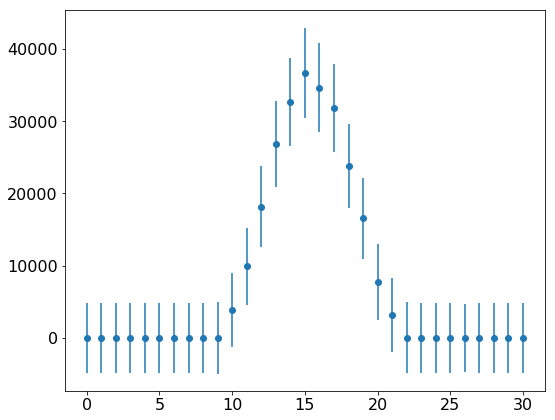

In [47]:
# process data
rm_metadata = np.asfarray(azsweep[:, DATA_START:], float)
avg_antennaT = np.mean(rm_metadata, axis=1)
rm_bg_antennaT = remove_background(avg_antennaT, tsys)
avg_brightnessT = antennaT_to_brightnessT(rm_bg_antennaT)

err_antennaT = np.sqrt(avg_antennaT)
err_brightnessT = antennaT_to_brightnessT(err_antennaT)

print(rm_bg_antennaT)

utils.init_plot()
utils.plot_data(range(31), avg_brightnessT, err_brightnessT)
plt.show()

In [42]:
# define diffraction model
import scipy.special
def circular_diffraction(theta, I, a):
    k = 29.7695032399
    return np.where(theta == 0, I, I * ( (2 * scipy.special.j1(k * a * np.sin(theta))) / (k * a * np.sin(theta)) )**2)
    

In [43]:
x = np.array([i*2*3.14/360 for i in range(-15, 16, 1)])
y = avg_brightnessT
ey = err_brightnessT

popt, perr, chisq = utils.fit_model(x, y, ey, (30000, 1), circular_diffraction)
print(popt, perr, chisq)

[  3.66580475e+04   9.58788007e-01] [  3.25683168e+03   8.30164939e-02] 13.0745730176


/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


/home/evan/.env/jlab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


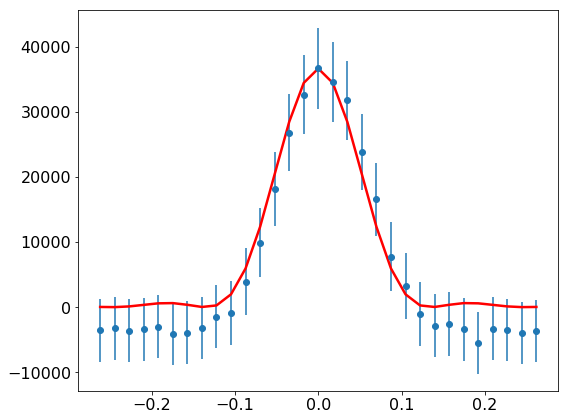

In [44]:
utils.init_plot()
utils.plot_data(x, y, ey)
utils.plot_model(x, circular_diffraction, popt, 'r', '')
plt.show()